In [1]:
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
# Class to load the data from the csv file.
class Sequences(Dataset):
    def __init__(self,path):
        df = pd.read_csv(path)
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005) 
        self.sequences = self.vectorizer.fit_transform(df.review.tolist()) # discrete vector of a review 
        self.labels = df.sentiment.tolist() # positive/negative review
        self.labels = [1 if label == 'positive' else 0 for label in self.labels]
        self.token2idx = self.vectorizer.vocabulary_ # dictionary with the word count
        self.idx2token = {idx: token for token, idx, in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i,:].toarray(), self.labels[i]
    def __len__(self):
        return self.sequences.shape[0]

In [3]:
path = '/Users/babyhandzzz/Desktop/ELEPH@NT/Datasets/IMDB Dataset.csv'

In [4]:
# Loading Data
dataset = Sequences(path)
train,test = random_split(dataset,[35000,15000])
# This thing is feeding the data to the net itself.
train = DataLoader(train, batch_size=64)
test = DataLoader(test, batch_size=15000)

In [5]:
# NN structure
class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super(BagOfWordsClassifier, self).__init__() # what does super do?
        self.fc1 = nn.Linear(vocab_size, hidden1) # input size to hidden1 size
        self.fc2 = nn.Linear(hidden1, hidden2) # hidden1 size to hidden2 size
        self.fc3 = nn.Linear(hidden2, 1) # hidden2 size to 1 (binary problem => single output)
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float())) # squeeze is unclear
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
# is the first argument the length of our vocabulary?
model = BagOfWordsClassifier(len(dataset.token2idx), 128, 64)
model

BagOfWordsClassifier(
  (fc1): Linear(in_features=2891, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
# Loss Function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:

train_loss = []
model.train()
epoch_ = 5

for epoch in range(epoch_):
    print('Epoch: {}'.format(epoch))
    for inputs, target in train:
        #print(target[:10])
        #break
        model.zero_grad() # clear all the gradients
        output = model(inputs)
        loss = criterion(output.squeeze(), target.float()) #why convert target to float
        loss.backward()
        optimizer.step()
    train_loss.append(loss.item())
    print('Loss: {}'.format(loss.item()))

Epoch: 0
Loss: 0.049677226692438126
Epoch: 1
Loss: 0.07823546975851059
Epoch: 2
Loss: 0.00378167862072587
Epoch: 3
Loss: 0.006702319718897343
Epoch: 4
Loss: 0.0002699602337088436


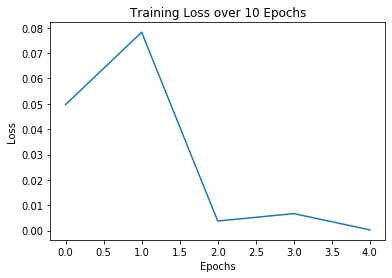

In [14]:
plt.plot(list(range(len(train_loss))),train_loss)
plt.title('Training Loss over 10 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
model.eval()
#with torch.no_grad():
for inputs, target in test:
            output = model(inputs) # generate output
            prediction = torch.sigmoid(output).tolist() # strangely sigmoid is used here and not in the net iself.
            prediction = np.array(prediction).reshape(1,-1) 
            prediction = np.where(prediction<0.5,0,1).squeeze() # manipulations to put it into a format suitable for comparison against the target vector.
            #print(prediction)
            target_vector = target.numpy()

            comparison_vector = target_vector - prediction
            accuracy = sum(1 for val in comparison_vector if val==0)/ len(comparison_vector)
            print(round(accuracy,4))

0.8594


In [18]:
df = pd.read_csv('/Users/babyhandzzz/Desktop/ELEPH@NT/Datasets/IMDB Dataset.csv')[:10]

In [42]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [51]:
def predict_sentiment(text):
    model.eval()
    with torch.no_grad():
        test_vector = torch.LongTensor(dataset.vectorizer.transform(text).toarray()) # [text]
        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'{prediction:0.3}: Sentiment is positive')
        else:
            print(f'{prediction:0.3}: Sentiment is negative')

In [54]:
#https://www.imdb.com/title/tt1213644/?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=c28fd853-7526-417a-ad2b-02e76562a472&pf_rd_r=7ZVC1ZTDKHPQYFYV98NT&pf_rd_s=center-1&pf_rd_t=15506&pf_rd_i=bottom&ref_=chtbtm_tt_1

review = ["This movie was on TV once so I decided to watch it since I wouldn't have to pay any money for it.The main character Will (played by Matt Lanter) has a dream where he meets a stone age Amy Winehouse (I think it's supposed to be a joke) who tells him that the world is going to end the day this movie premiered in the cinema (Coincidence?) and to stop it they must find a crystal skull. Matt later wakes up to celebrate his super-sweet sixteenth birthday (despite him being in his twenties) in a scene where we get one unfunny joke and celebrity impersonation after another. Then disaster strikes (it seems kinda redundant though since this movie already is one), hurricanes, earthquakes, meteorites and other classic disaster movie ingredients hit planet earth one after another. Will, followed by his friends: Juney (Crista Flanagan), Calvin (Gary G Thang Johnson), and Lisa (Kim Kardashian) go out into the city and tries to find his girlfriend and a safe place and later realizes that he has to find the crystal skull to set things right.The problem with this movie is, just like other movies by Jason Friedberg and Aaron Seltzer, that it doesn't stay on the theme but goes all over the place and try to spoof almost every popular movie that was made that year. And I use the term spoof lightly. Once again Seltzerberger show that they only grasp the most superficial concept of what humor is and never really bother to dig deeper and see what it is that makes things funny. Sometimes doing things outside the theme can work but not if it takes up a majority of the movie. And (for me) this movie is worse than Epic Movie. Yes you read right, Worse than Epic Movie. That movie at least had a story. Sure it was borrowed and crapified but at least it was a story. In this movie, everything that happens during the second act, when they try to find a safe place/figure out where they should go, just feels like a filler where the gang stumble into one reference after another. Seltzerberger's over-reliance on potty humor, movie/TV references, random musical numbers, deliberately obvious stunt-doubles and crappy special effects does not save them this time.Seltzer and Friedberg, your movie sucks horribly. If I may paraphrase a line from Billy Madison Id like to say: I awardyou only one star, and may God have mercy on your souls.Once again, if you want to see a GOOD movie made in the style that this train wreck was trying (and failing) to emulate, watch Hotshots Airplane!, The naked gun movies, Top Secret instead."]

In [56]:
predict_sentiment(review)

8.33e-19: Sentiment is negative
